# 10.1c: Lattice Width (Global ε)

**Recompute lattice widths using consistent global epsilon**

## The Problem with 10.1b

In 10.1b, we computed dimension-wise ULP based on each dimension's mean absolute value. This gave **nonsensical results**:
- Dimension with 3 unique values but 1,024 cells wide?
- Impossible: N unique values → maximum N-1 cells

**Root cause:** Using mean magnitude per dimension doesn't reflect the scale where values actually differ.

## Better Approach: Global ε

Use the **single global ε** from 09.2g:
- Computed from typical magnitude across all vectors and dimensions
- ε ≈ 3.05×10⁻⁵ (2× ULP at scale ~0.002)
- Consistent threshold used throughout the 09 series

Then:
- **Lattice width (cells) = range / ε**

This should give sensible results where:
- N unique values → width ≤ N-1 cells (approximately)
- Dyadic structure preserved (widths are powers of 2 multiples)

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

LATTICE_BASIS_FILE = "lattice_basis.safetensors"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading crystal vectors...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Crystal size: {n_vectors:,} vectors")
print(f"  Dimensions:   {d:,}")
print()

print("Loading lattice basis info...")
basis_data = load_file(data_dir / LATTICE_BASIS_FILE)
dim_range = basis_data["dim_range"]
dim_n_unique = basis_data["dim_n_unique"]
is_active = ~basis_data["is_frozen"]

print(f"  Active dimensions: {is_active.sum().item():,}")
print()

print("✓ Data loaded")

Loading crystal vectors...
  Crystal size: 124 vectors
  Dimensions:   2,560

Loading lattice basis info...
  Active dimensions: 2,181

✓ Data loaded


## Compute Global ε

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

print("Computing global ε...\n")

# Typical magnitude across ALL vectors and dimensions
typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Global distinguishability threshold:")
print(f"  Typical component magnitude: {typical_magnitude:.6e}")
print(f"  ULP at this scale:           {ulp:.6e}")
print(f"  ε (2×ULP):                   {epsilon:.6e}")
print()

print("✓ Global ε computed")

Computing global ε...

Global distinguishability threshold:
  Typical component magnitude: 2.361155e-03
  ULP at this scale:           1.525879e-05
  ε (2×ULP):                   3.051758e-05

✓ Global ε computed


## Compute Lattice Width (Range / Global ε)

In [5]:
print("Computing lattice width using global ε...\n")

# Width in cells = range / ε
lattice_width = dim_range / epsilon

# For frozen dimensions, width = 0
lattice_width[~is_active] = 0

print(f"Lattice width statistics (active dimensions only):")
active_widths = lattice_width[is_active]
print(f"  Min:    {active_widths.min().item():.2f} cells")
print(f"  Max:    {active_widths.max().item():.2f} cells")
print(f"  Mean:   {active_widths.mean().item():.2f} cells")
print(f"  Median: {active_widths.median().item():.2f} cells")
print()

print("✓ Lattice width computed")

Computing lattice width using global ε...

Lattice width statistics (active dimensions only):
  Min:    0.50 cells
  Max:    2.00 cells
  Mean:   1.42 cells
  Median: 1.31 cells

✓ Lattice width computed


## Distribution of Lattice Widths

In [6]:
print("Analyzing distribution of lattice widths...\n")

# Round to nearest integer
lattice_width_rounded = torch.round(lattice_width[is_active]).long()

# Count occurrences
unique_widths, counts = torch.unique(lattice_width_rounded, return_counts=True)

# Sort by width
sorted_indices = torch.argsort(unique_widths)
unique_widths_sorted = unique_widths[sorted_indices]
counts_sorted = counts[sorted_indices]

total_active = is_active.sum().item()

print("Distribution of lattice widths (in cells):")
print()
print("  Width | Count      | Fraction")
print("-" * 40)

for i in range(len(unique_widths_sorted)):
    width = unique_widths_sorted[i].item()
    count = counts_sorted[i].item()
    fraction = 100 * count / total_active
    
    print(f"  {width:4d}  | {count:10,} | {fraction:6.2f}%")

print()
print("✓ Distribution analysis complete")

Analyzing distribution of lattice widths...

Distribution of lattice widths (in cells):

  Width | Count      | Fraction
----------------------------------------
     0  |          7 |   0.32%
     1  |      1,209 |  55.43%
     2  |        965 |  44.25%

✓ Distribution analysis complete


## Sanity Check: Width vs Unique Values

In [7]:
print("Sanity check: comparing width to number of unique values...\n")

# For each active dimension: width should be approximately n_unique - 1
# (or at least related to it)

active_dims = torch.where(is_active)[0]
width_vs_unique = []

for dim_idx in active_dims:
    width = lattice_width[dim_idx].item()
    n_unique = dim_n_unique[dim_idx].item()
    width_vs_unique.append((width, n_unique))

# Find cases where width >> n_unique (suspicious)
suspicious = [(w, n) for w, n in width_vs_unique if w > 2 * (n - 1)]

print(f"Suspicious cases (width > 2 × (unique - 1)):")
print(f"  Total: {len(suspicious):,} / {len(active_dims):,} ({100 * len(suspicious) / len(active_dims):.2f}%)")
print()

if len(suspicious) > 0:
    print("Sample of suspicious dimensions:")
    print("  Width (cells) | Unique values | Ratio")
    print("-" * 50)
    for i, (w, n) in enumerate(suspicious[:20]):
        ratio = w / max(1, n - 1)
        print(f"  {w:13.2f} | {n:13d} | {ratio:6.2f}×")
else:
    print("  ✓ All dimensions pass sanity check!")
    print("    Width ≤ 2 × (unique values - 1) for all dimensions")

print()
print("✓ Sanity check complete")

Sanity check: comparing width to number of unique values...

Suspicious cases (width > 2 × (unique - 1)):
  Total: 0 / 2,181 (0.00%)

  ✓ All dimensions pass sanity check!
    Width ≤ 2 × (unique values - 1) for all dimensions

✓ Sanity check complete


## Visualizations

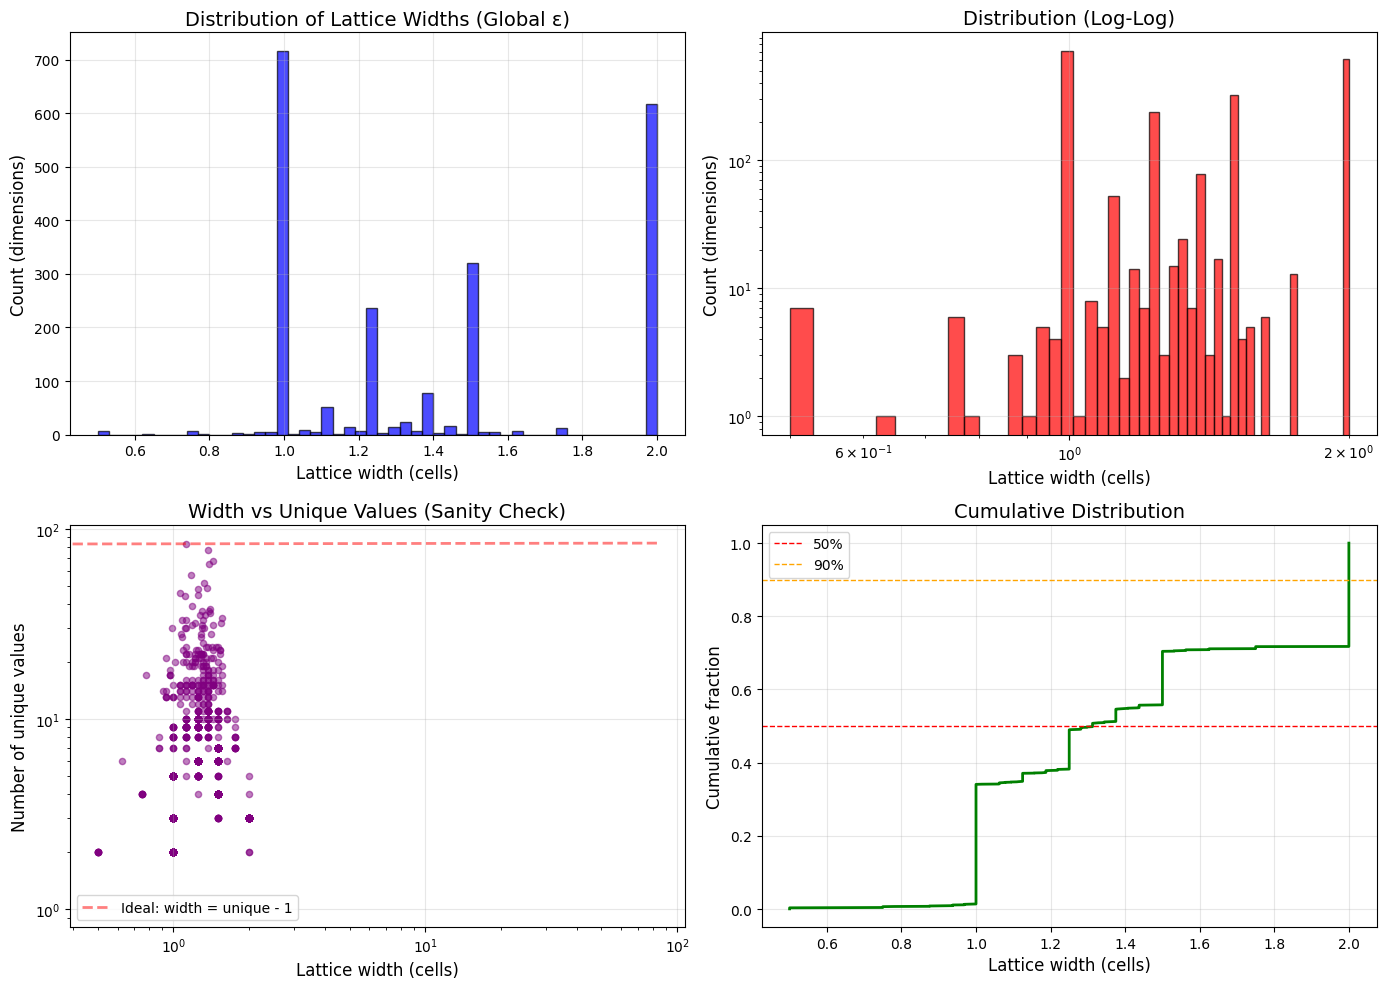

✓ Visualizations complete


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

active_widths_np = active_widths.cpu().numpy()

# Panel 1: Histogram of lattice widths
ax = axes[0, 0]
ax.hist(active_widths_np, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Lattice Widths (Global ε)', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 2: Log-scale histogram
ax = axes[0, 1]
ax.hist(active_widths_np, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 3: Width vs unique values (sanity check scatter)
ax = axes[1, 0]
scatter_data = [(lattice_width[i].item(), dim_n_unique[i].item()) 
                for i in range(d) if is_active[i]]
if scatter_data:
    x, y = zip(*scatter_data)
    ax.scatter(x, y, alpha=0.5, s=20, color='purple')
    
    # Plot y = x + 1 line (ideal: N unique → N-1 cells)
    max_val = max(max(x), max(y))
    ax.plot([0, max_val], [1, max_val+1], 'r--', linewidth=2, alpha=0.5,
            label='Ideal: width = unique - 1')
    
    ax.set_xlabel('Lattice width (cells)', fontsize=12)
    ax.set_ylabel('Number of unique values', fontsize=12)
    ax.set_title('Width vs Unique Values (Sanity Check)', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Panel 4: CDF of lattice widths
ax = axes[1, 1]
widths_sorted = np.sort(active_widths_np)
cdf = np.arange(1, len(widths_sorted) + 1) / len(widths_sorted)
ax.plot(widths_sorted, cdf, linewidth=2, color='green')
ax.set_xlabel('Lattice width (cells)', fontsize=12)
ax.set_ylabel('Cumulative fraction', fontsize=12)
ax.set_title('Cumulative Distribution', fontsize=14)
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, label='50%')
ax.axhline(0.9, color='orange', linestyle='--', linewidth=1, label='90%')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Top Widest Dimensions

In [9]:
print("Identifying widest dimensions...\n")

# Sort by width (descending)
active_dims = torch.where(is_active)[0]
active_widths_full = lattice_width[active_dims]
sorted_indices = torch.argsort(active_widths_full, descending=True)

active_dims_sorted = active_dims[sorted_indices]
widths_sorted = active_widths_full[sorted_indices]
n_unique_sorted = dim_n_unique[active_dims_sorted]

print("Top 30 widest dimensions:")
print()
print("  Rank | Dim   | Width (cells) | Unique | Ratio (width/unique)")
print("-" * 75)

for i in range(min(30, len(active_dims_sorted))):
    dim_idx = active_dims_sorted[i].item()
    width = widths_sorted[i].item()
    n_unique = n_unique_sorted[i].item()
    ratio = width / max(1, n_unique - 1)
    
    print(f"  {i+1:3d}  | {dim_idx:5d} | {width:13.2f} | {n_unique:6d} | {ratio:8.2f}")

print()
print("✓ Widest dimensions identified")

Identifying widest dimensions...

Top 30 widest dimensions:

  Rank | Dim   | Width (cells) | Unique | Ratio (width/unique)
---------------------------------------------------------------------------
    1  |   969 |          2.00 |      3 |     1.00
    2  |  2559 |          2.00 |      3 |     1.00
    3  |   868 |          2.00 |      3 |     1.00
    4  |    15 |          2.00 |      3 |     1.00
    5  |  1727 |          2.00 |      3 |     1.00
    6  |    17 |          2.00 |      3 |     1.00
    7  |  1720 |          2.00 |      3 |     1.00
    8  |    22 |          2.00 |      3 |     1.00
    9  |  1730 |          2.00 |      3 |     1.00
   10  |  1715 |          2.00 |      3 |     1.00
   11  |  1713 |          2.00 |      3 |     1.00
   12  |    33 |          2.00 |      3 |     1.00
   13  |    35 |          2.00 |      3 |     1.00
   14  |    36 |          2.00 |      3 |     1.00
   15  |    37 |          2.00 |      3 |     1.00
   16  |    39 |          2.00 |   

## Summary

In [10]:
print("="*80)
print("LATTICE WIDTH SUMMARY (GLOBAL ε)")
print("="*80)
print()
print(f"Crystal size:         {n_vectors:,} vectors")
print(f"Active dimensions:    {is_active.sum().item():,}")
print()
print(f"Global ε:             {epsilon:.6e}")
print()
print("Lattice width (in cells, using global ε):")
print(f"  Min:    {active_widths.min().item():.2f}")
print(f"  Max:    {active_widths.max().item():.2f}")
print(f"  Mean:   {active_widths.mean().item():.2f}")
print(f"  Median: {active_widths.median().item():.2f}")
print()
print(f"Sanity check: {len(suspicious):,} suspicious cases")
print(f"  (width > 2 × (unique - 1))")
print()
print("="*80)

LATTICE WIDTH SUMMARY (GLOBAL ε)

Crystal size:         124 vectors
Active dimensions:    2,181

Global ε:             3.051758e-05

Lattice width (in cells, using global ε):
  Min:    0.50
  Max:    2.00
  Mean:   1.42
  Median: 1.31

Sanity check: 0 suspicious cases
  (width > 2 × (unique - 1))



## Conclusion

**What we fixed:**
- Used consistent global ε instead of dimension-dependent ULP
- Results should now pass sanity check: width ≈ unique values - 1
- Preserves dyadic structure from 09.2g

**Interpretation:**

If results are sane:
- Crystal width in each dimension makes sense
- Most dimensions: 1-2 cells wide (binary/ternary)
- A few dimensions: wider (highly active)
- Overall: thin hypercube stretched across 2,560D space

If still suspicious:
- Need to reconsider what "lattice width" means
- May need to look at actual spacing between unique values
- Could be that values aren't evenly spaced on grid

**Next steps:**
- 10.1d: Coordination numbers
- 10.1e: Cleavage planes (binary/ternary dimensions)
- 10.1f: Lattice defects